# ClusterMap for MERFISH Mouse Gut

Adapted from [ClusterMap_STARmap_V1_1020_BY1.ipynb](https://github.com/wanglab-broad/ClusterMap/blob/main/ClusterMap_STARmap_V1_1020_BY1.ipynb)

In [1]:
import sys
sys.path.append('../../../../ClusterMap')
sys.path.append('../../../scripts/')

In [2]:
from ClusterMap.clustermap import *
from anndata import AnnData
import tifffile
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import scipy.io
import math
from tqdm import tqdm
import pandas as pd
import numpy as np

%matplotlib inline

from paths import get_data_paths

In [3]:
from joblib import Parallel, delayed

def process_tile(out, tile_num):
    spots_tile=out.loc[tile_num,'spots']
    dapi_tile=out.loc[tile_num,'img']

    ### instantiate model
    model_tile = ClusterMap(
        spots=spots_tile, dapi=dapi_tile, gene_list=gene_list, num_dims=num_dims,
        xy_radius=xy_radius,z_radius=0,fast_preprocess=False
    )

    ###preprocessing
    model_tile.preprocess(dapi_grid_interval=3, pct_filter=0)

    # ### segmentation
    model_tile.min_spot_per_cell=5
    model_tile.segmentation(cell_num_threshold=0.1,dapi_grid_interval=3,add_dapi=True,use_genedis=True)

    # ### plot cell segmentation results in spots (colored by cells)
    # model_tile.plot_segmentation(figsize=(4,4),s=0.01,plot_with_dapi=True,plot_dapi=True, show=False)
    return model_tile

## Read spots and dapi image-BY3

In [4]:
data_path = get_data_paths('../../../data_mapping.yml')['mouse_gut']

In [5]:
### set file folder
filepath = data_path / 'comseg_format'

### read dapi: col, row, z
dapi = tifffile.imread(data_path / 'raw_data' / 'dapi_stack.tif')[4,:,:]
dapi_bin = tifffile.imread(data_path / 'data_analysis' / 'cellpose' / 'cell_boundaries' / 'results' / 'cellpose_dapi.tif')[4,:,:]

### read spots
spots = pd.read_csv(filepath / 'data.csv')
spots = spots[['gene', 'x', 'y', 'z']]
spots.columns=['gene_name','spot_location_1','spot_location_2','spot_location_3']

### convert gene_name to gene identity
genes=pd.DataFrame(spots['gene_name'].unique())
a1=list(genes[0])
gene=list(map(lambda x: a1.index(x)+1, spots['gene_name']))
spots['gene']=gene
spots['gene']=spots['gene'].astype('int')

We tried different parameters for `xy_radius`, but it didn't improve the results.

In [6]:
### set radius parameters
xy_radius=15

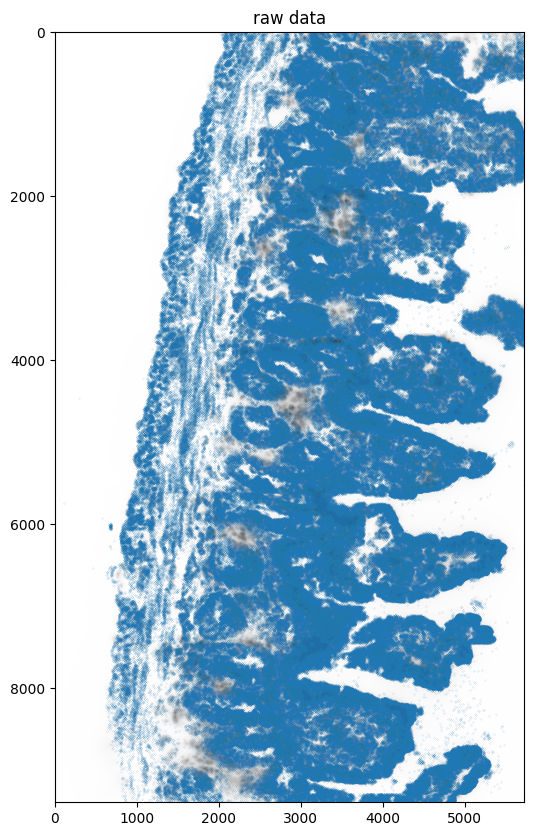

In [10]:
### overview
plt.figure(figsize=(10,10))
plt.imshow(dapi,cmap='Greys')
plt.scatter(spots['spot_location_1'],spots['spot_location_2'],s=0.005)
plt.title('raw data')
plt.show()

In [11]:
num_gene=np.max(spots['gene'])

gene_list=np.arange(1,num_gene+1)
num_dims=len(dapi.shape)

## Run ClusterMap on default DAPI segmentation

In [12]:
model = ClusterMap(spots=spots, dapi=dapi, gene_list=gene_list, num_dims=num_dims,
                   xy_radius=xy_radius,z_radius=0,fast_preprocess=True)

In [13]:
%%time
img = dapi
window_size=1500
label_img = get_img(img, spots, window_size=window_size, margin=math.ceil(window_size*0.1))
out = split(img, label_img, spots, window_size=window_size, margin=math.ceil(window_size*0.1))

Split finished: 28 tiles
CPU times: user 2.69 s, sys: 462 ms, total: 3.15 s
Wall time: 3.15 s


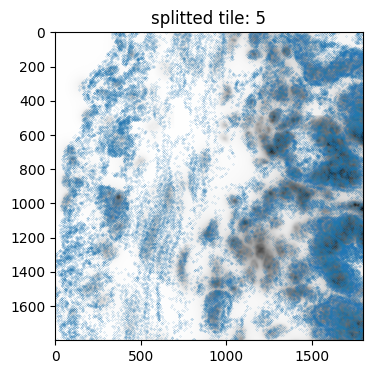

In [14]:
###plot a tile
tile_num=5
plt.figure(figsize=(4,4))
plt.imshow(out.loc[tile_num,'img'],cmap='Greys')

plt.scatter(out.loc[tile_num,'spots']['spot_location_1'],
            out.loc[tile_num,'spots']['spot_location_2'],s=0.01)
plt.title(f'splitted tile: {tile_num}')
plt.show()

### cell segmentation on each tile

In [ ]:
%%time
tile_models = Parallel(n_jobs=-1)(delayed(process_tile)(out, tile_num) for tile_num in range(out.shape[0]))

In [16]:
model.spots['clustermap'] = -1
for tile_num in range(out.shape[0]):
    model.stitch(tile_models[tile_num],out,tile_num)

Postprocessing
Postprocessing
Postprocessing
Postprocessing
Postprocessing
Postprocessing
Postprocessing
Postprocessing
Postprocessing
Postprocessing
Postprocessing
Postprocessing
Postprocessing
Postprocessing
Postprocessing
Postprocessing
Postprocessing
Postprocessing
Postprocessing
Postprocessing
Postprocessing
Postprocessing
Postprocessing
Postprocessing
Postprocessing
Postprocessing
Postprocessing
Postprocessing


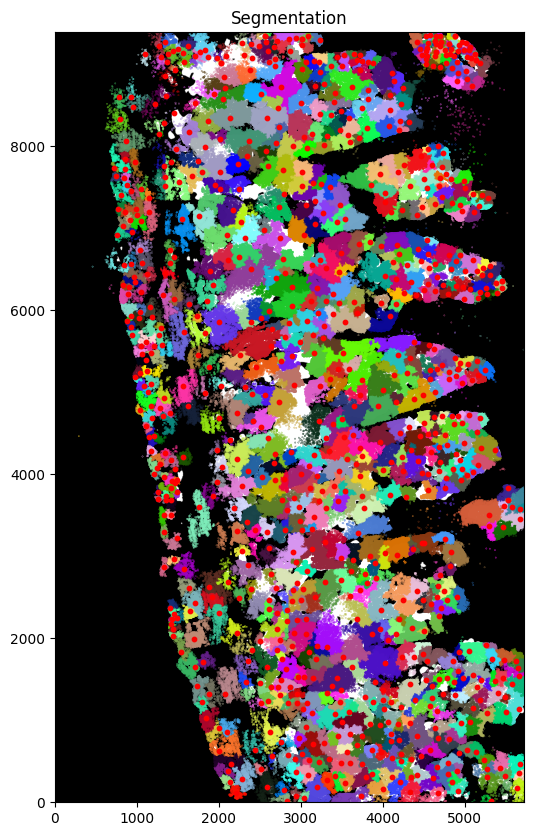

In [17]:
model.plot_segmentation(figsize=(20,10),s=0.05,plot_with_dapi=False,plot_dapi=True, show=False)
plt.scatter(model.cellcenter_unique[:,1],model.cellcenter_unique[:,0],c='r',s=10)
plt.show()

## Run ClusterMap on CellPose DAPI segmentation

In [ ]:
%%time
img = dapi_bin
label_img = get_img(img, spots, window_size=window_size, margin=math.ceil(window_size*0.1))
out_bin = split(img, label_img, spots, window_size=window_size, margin=math.ceil(window_size*0.1))

Split finished: 28 tiles
CPU times: user 2.65 s, sys: 472 ms, total: 3.12 s
Wall time: 3.12 s


In [ ]:
model_bin = ClusterMap(
    spots=spots, dapi=dapi_bin, gene_list=gene_list, num_dims=num_dims,
    xy_radius=xy_radius,z_radius=0,fast_preprocess=True
)

In [ ]:
%%time
tile_models_bin = Parallel(n_jobs=-1)(delayed(process_tile)(out_bin, tile_num) for tile_num in range(out.shape[0]))

In [ ]:
model_bin.spots['clustermap'] = -1
for tile_num in range(out_bin.shape[0]):
    model_bin.stitch(tile_models_bin[tile_num], out_bin, tile_num)

Postprocessing
Postprocessing
Postprocessing
Postprocessing
Postprocessing
Postprocessing
Postprocessing
Postprocessing
Postprocessing
Postprocessing
Postprocessing
Postprocessing
Postprocessing
Postprocessing
Postprocessing
Postprocessing
Postprocessing
Postprocessing
Postprocessing
Postprocessing
Postprocessing
Postprocessing
Postprocessing
Postprocessing
Postprocessing
Postprocessing
Postprocessing
Postprocessing


In [ ]:
model.cellid_unique.size

886

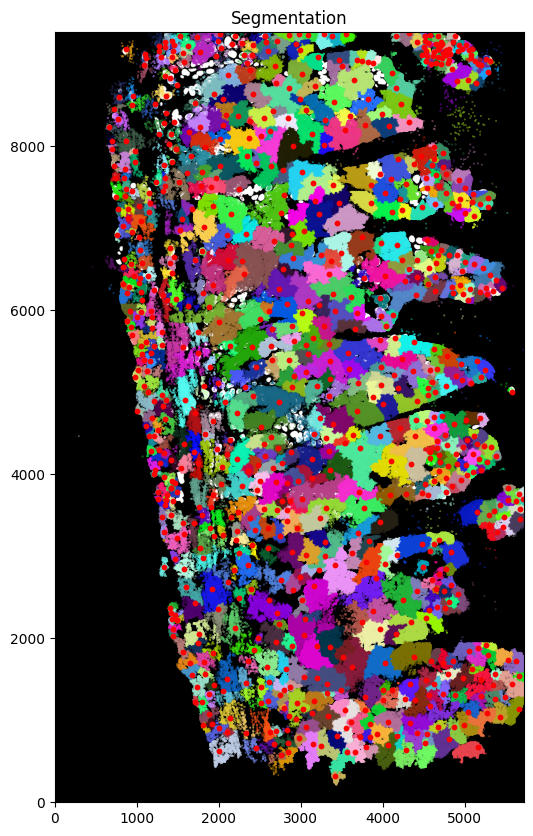

In [ ]:
model_bin.plot_segmentation(figsize=(20,10),s=0.05,plot_with_dapi=False,plot_dapi=True, show=False)
plt.scatter(model_bin.cellcenter_unique[:,1],model_bin.cellcenter_unique[:,0],c='r',s=10)
plt.show()

## Save cell segmentation results

In [25]:
path_save = data_path / 'seg_method_results' / 'clustermap'
model.save_segmentation(path_save / 'spots_all.csv')
model_bin.save_segmentation(path_save / 'spots_all_cellpose.csv')